In [1]:
# Numerical
from jax.numpy import exp, newaxis, mean   # Arithematic
from jax.numpy import array, zeros, arange, where, ones # Array creation routines
from jax.numpy import float64
from jax.numpy import sum as vsum
from jax.numpy.linalg import solve, eigvals, norm
from jax.random import PRNGKey, uniform
from jax.lax import scan 
from jax import jit, jacrev, jacfwd, vmap, grad, jvp, vjp

# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

# Visualisation
import matplotlib.pyplot as plt

In [2]:
import jax.numpy as np

In [3]:
def construct_analytic_solution():
    """
    This creates a closure environment that pre-calculates the eigenvalues of the transfer matrix and the coefficients that produce the approriate initial state.
    """
    cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    cbm.compile()

    @partial(jit, static_argnums=(5))
    def analytic_solution(time, start, area, weights, production_coefficients, carbon_box_model=cbm._matrix):
        """
        This is the analytic solution itself.
        
        Parameters: 
            time: Array -> The time values that the solution is to be evaluated at 
            coeffs: Array -> The coefficients associated with a particular initial condition. 
          
            eigenvals: Array -> The eigenvalues of the transfer matrix used to construct the linear superposition of the eigenfunctions
            eigenvecs: Array[Array] -> The eigenvectors of the transfer matrix used to construct the linear superposition of the eigenfunctions.
        
        Returns:
            Array -> The analytic solution evaluated at times
        """
        # I'm not sure that the weights logic actually works
        transfer_matrix = weights * carbon_box_model
        eigenvalues = eigvals(transfer_matrix).real    # Constructing the linear eigenfunctions
        production_coefficients = cbm._production_coefficients

        @jit
        @vmap
        def power_iteration(eigenval, /, iter_depth=11, matrix=transfer_matrix):
            identity = np.diag(array([eigenval for _ in range(11)], dtype=float64))
            A = matrix - identity
            # Ideally choose a random vector
            # To decrease the chance that our vector
            # Is orthogonal to the eigenvector
            b_k = uniform(PRNGKey(0), (transfer_matrix.shape[1],))

            def scan_fun(b_k, _, /, matrix=A):
                # calculate the matrix-by-vector product Ab
                A_inv = np.linalg.inv(matrix)
                b_k1 = np.dot(A_inv, b_k)

                # calculate the norm
                b_k1_norm = np.linalg.norm(b_k1)

                # re normalize the vector
                b_k = b_k1 / b_k1_norm
                return b_k, b_k

            eigenvec, _ = scan(scan_fun, b_k, None, length=iter_depth)
            return eigenvec

        eigenvectors = power_iteration(eigenvalues)
        soln = solve(eigenvectors, production_coefficients)
        soln = 1 / norm(soln) * soln    # Normalising the impulse 

        @jit
        @vmap
        def sum_util(coeff, eigenval, eigenvec, /, time=time, start=start, area=area):
            return area * coeff * exp(eigenval * (time - start))[:, newaxis] * eigenvec

        impulse = vsum(sum_util(soln, eigenvalues, eigenvectors.T), axis=0)
        return where(time.reshape(time.shape[0], 1) > start, impulse, zeros(impulse.shape))

    return analytic_solution

In [4]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = array([row.strip().split(" ") for row in data], dtype=float64)
        return data.T


In [5]:
analytic_solution = construct_analytic_solution()
data = load("miyake12.csv")
data = data.at[1].add(-mean(data[1, 1:4]))

In [6]:
@jit
def loss(parameters, /, analytic_solution=analytic_solution, data=data):
    start, area, weights, production_coefficients = parameters
    analytic_data = analytic_solution(data[0], start, area, weights, production_coefficients)
    return vsum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)

In [27]:
gradient = jit(grad(loss))
hessian = jit(jacrev(grad(loss)))

In [22]:
initial_params = (float64(774.86), float64(80.0), ones(11), array([0.7, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [138]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=False)
mcmc.run(PRNGKey(11), init_params=initial_params)

In [ ]:
test = mcmc.get_samples()

In [ ]:
import seaborn as sns

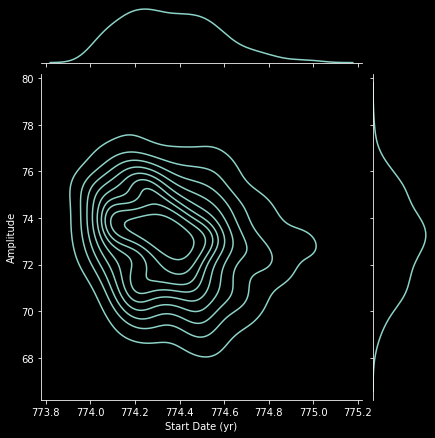

In [ ]:
posterior_plot = sns.jointplot(x=test[0], y=test[1], kind="kde")
posterior_plot.set_axis_labels("Start Date (yr)", "Amplitude")

So I need to work out how to create a valid cbm transfer matrix with as the same number of parameters as dimensions.

In [ ]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()